## Validate GPU Installation (NVIDIA ONLY)

In [ ]:
#!conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1

^C


In [ ]:
#!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:54:10_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.relgpu_drvr455TC455_06.29190527_0


## If conda install gpu doesnt work, use the following steps:
1. Go to this [link](https://developer.nvidia.com/rdp/cudnn-archive) and install cuDNN 8.1.1.
2. Extract the files.
3. Copy `bin\cudnn64_8.dll` → `C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin`
4. Copy `lib\x64\cudnn.lib` → `C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\lib\x64`
5. Copy `include\cudnn.h` → `C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\include`
6. Open **Windows Environment Variables**, and **Add these paths**:
```bash
C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin
C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\libnvvm\bin
C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\include
```
7. Verify
```bash
where cudnn64_8.dll
```

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Some debugging steps:
1. Move the nvvm folder into /models/research in the Tensorflow Object Detection API directory.

## Run fine-tuned model (ssd mobilenet v2 fpnlite 320x320 coco17) to predict images.

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from object_detection.utils import label_map_util

# Load the label map
label_map_path = "./mtsd_data/mtsd_label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(label_map_path, use_display_name=True)

# Load the saved model
detect_fn = tf.saved_model.load("./models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/exported_model/saved_model")

# Function to draw bounding boxes and labels inside the boxes
def draw_boxes_with_labels(image, boxes, classes, scores, category_index, min_score_thresh=0.4):
    """
    Draws bounding boxes and labels inside the boxes on the given image.
    
    Args:
        image: The image to draw on.
        boxes: Bounding box coordinates (normalized) from the model.
        classes: Detected class indices.
        scores: Detection scores.
        category_index: Mapping of class indices to class names.
        min_score_thresh: Minimum score threshold for displaying detections.
    
    Returns:
        Annotated image with bounding boxes and labels inside.
    """
    height, width, _ = image.shape
    for i in range(len(boxes)):
        if scores[i] >= min_score_thresh:
            # Scale the box to image dimensions
            ymin, xmin, ymax, xmax = boxes[i]
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            
            # Draw the rectangle
            color = (0, 255, 0)  # Green color
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

            # Get the label text
            class_id = int(classes[i])
            class_name = category_index[class_id]['name']
            label = f"{class_name}: {scores[i]:.2f}"

            # Calculate text size
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_thickness = 1
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

            # Text background coordinates (inside the bounding box)
            text_x = xmin + 2
            text_y = ymin + text_size[1] + 2
            text_bg_x = text_x + text_size[0]
            text_bg_y = text_y - text_size[1]

            # Draw text background rectangle (inside the box)
            cv2.rectangle(image, (xmin, ymin), (text_bg_x, text_bg_y), color, -1)

            # Draw the label text (inside the box)
            cv2.putText(
                image,
                label,
                (text_x, text_y),
                font,
                font_scale,
                (0, 255, 0),  # Black text
                font_thickness,
                lineType=cv2.LINE_AA,
            )

    return image

# Load an image
image_path = "./mtsd_data/mtsd_images/02_PNG_jpg.rf.70c5e13b9fadb831af5abb7e7bf33c2e.jpg"
image = cv2.imread(image_path)

# Convert the image to a tensor
input_tensor = tf.convert_to_tensor(image)
input_tensor = input_tensor[tf.newaxis, ...]

# Perform detection
detections = detect_fn(input_tensor)

# Extract detection details
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
boxes = detections['detection_boxes']
scores = detections['detection_scores']
classes = detections['detection_classes'].astype(np.int32)

# Draw detections on the image
annotated_image = draw_boxes_with_labels(
    image=image.copy(), 
    boxes=boxes, 
    classes=classes, 
    scores=scores, 
    category_index=category_index, 
    min_score_thresh=0.4
)

# Display the image with detections
cv2.imshow("Detections", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Run inference on test images.

In [71]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import pickle

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [72]:
# Path to test images and CSV dataset
DATASET_PATH = './mtsd_data/mtsd_test_images/'
CSV_PATH = './mtsd_data/test_dataset.csv'

# Load ground truth bounding boxes from CSV
gt_data = pd.read_csv(CSV_PATH)

# Convert CSV filename column to dictionary format
ground_truths = {}

for _, row in gt_data.iterrows():
    filename = row['filename']
    bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    class_name = row['class']

    if filename not in ground_truths:
        ground_truths[filename] = {'gt_bboxes': [], 'gt_classes': []}

    ground_truths[filename]['gt_bboxes'].append(bbox)
    ground_truths[filename]['gt_classes'].append(class_name)

In [73]:
def load_image_into_numpy_array(image_path):
    """ Load image and convert to numpy array """
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure 3 channels
    return np.array(image)

In [102]:
MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\exported_model'

# Define model path
MODEL_PATH = os.path.join('models', MODEL_NAME)  # Replace with your actual model name
model = tf.saved_model.load(os.path.join(MODEL_PATH, 'saved_model'))

# Get all image filenames
test_images = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Dictionary to store results
detections = {}

for image_path in test_images:
    image_np = load_image_into_numpy_array(image_path)

    # Convert image to tensor
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = tf.expand_dims(input_tensor, axis=0)  # Add batch dimension

    # Run inference
    detections_result = model.signatures['serving_default'](input_tensor)

    # Extract filename without path
    filename = os.path.basename(image_path)

    # Store results with updated key names
    detections[filename] = {
        'pred_bboxes': detections_result['detection_boxes'].numpy().tolist(),  # Predicted bounding boxes
        'pred_classes': detections_result['detection_classes'].numpy().astype(int).tolist(),  # Predicted class labels
        'confidences': detections_result['detection_scores'].numpy().tolist(),  # Prediction confidence scores
    }

    # Attach ground truth bounding boxes if available
    if filename in ground_truths:
        detections[filename]['gt_bboxes'] = ground_truths[filename]['gt_bboxes']
        detections[filename]['gt_classes'] = ground_truths[filename]['gt_classes']
    else:
        detections[filename]['gt_bboxes'] = []
        detections[filename]['gt_classes'] = []

print(f"Processed {len(detections)} images")

Processed 100 images


In [75]:
# Save detections to pickle file
PICKLE_PATH = os.path.join(MODEL_PATH, 'detections_output_result.pkl')

with open(PICKLE_PATH, 'wb') as f:
    pickle.dump(detections, f)

print(f"Detections saved to {PICKLE_PATH}")

Detections saved to models\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\exported_model\detections_output_result.pkl


## Evaluation

In [111]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [112]:
EPSILON = 1e-5
# Load mtsd testing images
CLASSES = ['Speed limit','Pass either side','Obstruction', 'Roadway diverges', 'Bumps']
#Path to the mtsd test dataset
DATASET_PATH = './mtsd_data/mtsd_test_images/'
test_set = [f for f in os.listdir(DATASET_PATH) if f.lower().endswith('.jpg')]

print("Test set size:", len(test_set))

Test set size: 100


In [113]:
category_index = {1: {'id': 1, 'name': 'Speed limit'},
 2: {'id': 2, 'name': 'Pass either side'},
 3: {'id': 3, 'name': 'Obstruction'},
 4: {'id': 4, 'name': 'Roadway diverges'},
 5: {'id': 5, 'name': 'Bumps'}}
categories = [{'id': 1, 'name': 'Speed limit'},
 {'id': 2, 'name': 'Pass either side'},
 {'id': 3, 'name': 'Obstruction'},
 {'id': 4, 'name': 'Roadway diverges'},
 {'id': 5, 'name': 'Bumps'}]

## Load detection results

In [114]:
MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\exported_model'

MODEL_PATH = os.path.join('models', MODEL_NAME)
with open(os.path.join(MODEL_PATH, 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

In [115]:
# Checking keys and gt_bbox for the detections
for file_path, det in detections.items():
    print(f"File: {file_path}, Keys: {list(det.keys())}")
    print(f"gt_bboxes: {det['gt_bboxes']}")
    break

File: 00418-1-_jpg.rf.bc1ee3c47d7a596bce73a0cfc707092a.jpg, Keys: ['pred_bboxes', 'pred_classes', 'confidences', 'gt_bboxes', 'gt_classes']
gt_bboxes: [[141, 293, 150, 306]]


## Helper codes

In [116]:
def filter_detections_by_width(detections, min_w, max_w):
    fdetects = {}  # Store filtered detections
    n_gt_bboxes = 0  # Counter for remaining ground truth boxes

    for file_path, det in detections.items():  # Iterate over dictionary items
        d_aux = copy.deepcopy(det)  # Make a deep copy to avoid modifying the original
        j = 0  # Counter to handle removed elements safely

        if 'gt_bboxes' in d_aux:  # Ensure key exists
            for i, bbox in enumerate(det['gt_bboxes']):
                w = bbox[2] - bbox[0]  # Calculate width

                if w < min_w or w >= max_w:  # Remove bbox if outside width range
                    d_aux['gt_bboxes'].pop(i - j)
                    d_aux['gt_classes'].pop(i - j)

                    # Remove corresponding prediction info if available
                    try:
                        d_aux['pred_bboxes'].pop(i - j)
                        d_aux['pred_classes'].pop(i - j)
                        d_aux['confidences'].pop(i - j)
                    except IndexError:
                        print(f"Pred bbox num {i} of image {os.path.basename(file_path)} was not removed")

                    j += 1  # Keep track of removed elements

        n_gt_bboxes += len(d_aux.get('gt_bboxes', []))  # Count remaining GT bboxes
        fdetects[file_path] = d_aux  # Store updated detection info

    print(f"Total remaining ground truth bounding boxes: {n_gt_bboxes}")
    return fdetects

In [143]:
def get_detection_by_filename(detections, filename):
    if filename not in detections:
        print(f"Warning: {filename} not found in detections.")
        return {'pred_bboxes': [[]], 'pred_classes': [[]], 'confidences': [[]], 'gt_bboxes': [], 'gt_classes': []}

    detection = detections[filename]

    return detection 

In [118]:
def plot_rectangle(bbox, ax, class_name, edgecolor, confidence=None):
    xmin, ymin, xmax, ymax = bbox
    left, right, top, bot = xmin, xmax, ymin, ymax

    # Draw bounding box
    ax.add_patch(
        plt.Rectangle((left, top),
                      right - left,
                      bot - top, fill=False,
                      edgecolor=edgecolor, linewidth=2)
    )

    # Define label format
    label = '{:s}:'.format(class_name)
    if confidence is not None:
        label += ' {0:.2f}%'.format(confidence)

    # Default label position
    label_pos_x = right + 10
    label_pos_y = ((bot - top) / 2) + top + 3.5

    # Label position of different classes
    # if class_name == 'Speed limit':
    #     label_pos_x = left
    #     label_pos_y = top - 12
    # elif class_name == 'Pass either side':
    #     label_pos_x = left - 30
    #     label_pos_y = bot + 15
    # elif class_name == 'Obstruction':
    #     label_pos_x = right + 10
    #     label_pos_y = bot - 5
    # elif class_name == 'Roadway diverges':
    #     label_pos_x = left + 5
    #     label_pos_y = top - 20
    # elif class_name == 'Bumps':
    #     label_pos_x = left - 10
    #     label_pos_y = bot + 10

    # Draw label text
    ax.text(label_pos_x, label_pos_y, label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=1),
            fontsize=11)

In [119]:
# Color mapping for each class
CLASSES_COLOR = ['DarkOrange', 'Aqua', 'Chartreuse', 'Red', 'Blue']

def plot_dets(detection, filename):
    """
    Plots detected bounding boxes and ground truth on the original image.

    Args:
        detection: Dictionary containing 'pred_bboxes', 'pred_classes', 'confidences', 'gt_bboxes', 'gt_classes'.
        filename: The image filename to construct full path.
    """
    fig, ax = plt.subplots(figsize=(12, 12))

    # Construct valid file path
    file_path = os.path.join(DATASET_PATH, filename)

    # Ensure file exists before opening
    if not os.path.exists(file_path):
        print(f"⚠️ Warning: File {file_path} not found!")
        return

    # Load and display image
    image = np.array(Image.open(file_path).convert('RGB'))
    ax.imshow(image, aspect='equal')

    # Ensure the detection data is in correct format
    pred_bboxes = detection['pred_bboxes'][0]  # Extract first list
    pred_classes = detection['pred_classes'][0]
    confidences = detection['confidences'][0]

    # Draw predicted bounding boxes
    for j in range(len(pred_bboxes)):
        pred_class = pred_classes[j]
        bbox = pred_bboxes[j]
        confidence = confidences[j] * 100  # Convert to percentage

        # Ensure valid class ID
        if pred_class not in category_index:
            print(f"⚠️ Warning: Class ID {pred_class} not found in category_index!")
            continue

        # Plot predicted bounding box
        plot_rectangle(bbox, ax, category_index[pred_class]['name'], CLASSES_COLOR[pred_class-1], confidence)

    # Draw ground truth bounding boxes
    if 'gt_bboxes' in detection and 'gt_classes' in detection:
        for j in range(len(detection['gt_bboxes'])):
            gt_bbox = detection['gt_bboxes'][j]
            gt_class = detection['gt_classes'][j]

            # Get color index (assume ground truth class names are in categories)
            gt_class_id = next((c['id'] for c in categories if c['name'] == gt_class), None)
            gt_color = CLASSES_COLOR[gt_class_id-1] if gt_class_id else 'black'

            # Plot ground truth bounding box
            plot_rectangle(gt_bbox, ax, gt_class, gt_color)

    plt.axis('off')
    plt.show()

In [120]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [121]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [122]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [123]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [124]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [125]:
def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    n_gt_bboxes = 0
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1. # true positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1. # false positive (multiple detection)
        else:
            fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    
    print("TP: {}".format(tp[-1]))
    print("FP: {}".format(fp[-1]))
    print("FN: {}".format(fn))
    class_name = category_index[cls]['name']
    print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
    
    print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
    print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [126]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [127]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
    plt.savefig('gtsdb_pre_rec_curves.pdf', format='pdf')
    plt.show()
    plt.clf()

In [128]:
# Function to convert class names to numerical IDs
def get_class_id(class_name):
    for category in categories:
        if category['name'] == class_name:
            return category['id']
    return None  # Return None if class not found

def compute_mean_average_precision(detections):
    """
    Compute the Mean Average Precision (mAP) for object detection evaluation.

    INPUTS:
    - detections: dictionary {filename: {pred_bboxes, pred_classes, confidences, gt_bboxes, gt_classes}}
    
    OUTPUTS:
    - mAP: float
    """
    
    results = []
    plot_data = []
    aps = []

    # Convert detections dictionary to list for processing
    detection_list = []
    for filename, data in detections.items():
        # Convert gt_classes (class names) to numeric IDs
        gt_class_ids = [get_class_id(c) for c in data['gt_classes'] if get_class_id(c) is not None]

        detection_list.append({
            'file': filename,
            'pred_bboxes': data['pred_bboxes'],
            'pred_classes': data['pred_classes'],
            'confidences': data['confidences'],
            'gt_bboxes': data['gt_bboxes'],
            'gt_classes': gt_class_ids # Use numeric class IDs
        })

    # Compute precision-recall for each category
    for category in categories:
        class_id = category['id']
        class_name = category['name']

        # Match ground truth and compute precision, recall, AP
        rec, prec, ap = match_gts_and_compute_prec_recall_ap(class_id, detection_list, iouthresh=0.5)

        if rec is None:
            continue

        results.append({'class': class_name, 'precision': prec[-1], 'recall': rec[-1], 'ap': ap})
        plot_data.append({'class': class_name, 'precision': prec, 'recall': rec, 'ap': ap})

        if ap is not None:
            aps.append(ap)
            print(f'AP for {class_name} = {ap:.4f}')
        plot_precision_recall(prec, rec, ap)

    if aps:
        mAP = np.mean(aps)
        print(f'Mean AP = {mAP:.4f}')
    else:
        mAP = 0.0
        print("No AP values computed.")

    print('~~~~~~~~')
    print('Results:')
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    print(df)
    
    plot_full_precision_recall(plot_data)
    
    return mAP

## Filter detections

In [129]:
# (0,32) (32,46) (46,1000)
detections_small = filter_detections_by_width(detections, 0, 32)
detections_medium = filter_detections_by_width(detections, 32, 46)
detections_large = filter_detections_by_width(detections, 46, 1000)

Total remaining ground truth bounding boxes: 5
Total remaining ground truth bounding boxes: 14
Total remaining ground truth bounding boxes: 80


In [130]:
import tensorflow as tf

def apply_nms(detection, iou_threshold=0.01):
    """
    Applies Non-Maximum Suppression (NMS) to remove redundant overlapping detections.

    Args:
        detection (dict): A dictionary containing 'pred_bboxes', 'pred_classes', and 'confidences'.
        iou_threshold (float): IoU threshold for NMS.

    Returns:
        dict: Filtered detections after applying NMS.
    """
    if not detection['pred_bboxes'][0]:  # Check if there are no predictions
        return detection

    bboxes = np.array(detection['pred_bboxes'][0])  # Convert to numpy array
    scores = np.array(detection['confidences'][0])
    classes = np.array(detection['pred_classes'][0])

    # Apply NMS using TensorFlow
    selected_indices = tf.image.non_max_suppression(
        boxes=bboxes,
        scores=scores,
        max_output_size=20,  # Limit to top 20 detections
        iou_threshold=iou_threshold,
        score_threshold=0.3  # Minimum confidence
    )

    selected_indices = selected_indices.numpy()  # Convert Tensor to numpy

    # Keep only the selected boxes
    detection['pred_bboxes'] = [[bboxes[i].tolist() for i in selected_indices]]
    detection['pred_classes'] = [[classes[i] for i in selected_indices]]
    detection['confidences'] = [[scores[i] for i in selected_indices]]

    return detection

# Apply NMS to all detections
for filename, detection in detections.items():
    detections[filename] = apply_nms(detection)

print("Applied Non-Maximum Suppression (NMS).")

Applied Non-Maximum Suppression (NMS).


In [131]:
for filename, detection in detections.items():
    print(f"Filename: {filename}")
    print(f"Predicted BBoxes: {detection['pred_bboxes']}")
    print(f"Predicted Classes: {detection['pred_classes']}")
    print(f"Confidences: {detection['confidences']}")

Filename: 00418-1-_jpg.rf.bc1ee3c47d7a596bce73a0cfc707092a.jpg
Predicted BBoxes: [[]]
Predicted Classes: [[]]
Confidences: [[]]
Filename: 007_0032_png.rf.42a278dcba877fb54b76eaf3d781456a.jpg
Predicted BBoxes: [[[0.03669688105583191, 0.02908855676651001, 0.9502863883972168, 0.9431764483451843]]]
Predicted Classes: [[2]]
Confidences: [[0.7556074857711792]]
Filename: 007_0074_png.rf.244e904d1d9ac5587b2ac3c0f82a739a.jpg
Predicted BBoxes: [[[0.037908077239990234, 0.025867819786071777, 0.9575344920158386, 0.9400168061256409]]]
Predicted Classes: [[2]]
Confidences: [[0.7551751732826233]]
Filename: 03_PNG_jpg.rf.b4cd2e4f47e993bd5a9416c0f46c1535.jpg
Predicted BBoxes: [[[0.025871098041534424, 0.02984851598739624, 0.9455621242523193, 0.9356245398521423]]]
Predicted Classes: [[2]]
Confidences: [[0.6176600456237793]]
Filename: 0_00004_00019-ppm_jpg.rf.56d95ce6322573e857411c476b37f06e.jpg
Predicted BBoxes: [[[0.048596084117889404, 0.030185699462890625, 0.9542824625968933, 0.9436315894126892]]]
Predi

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit = 0.0000


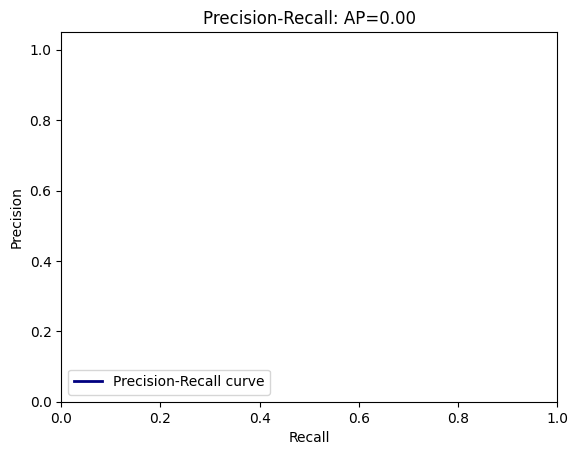

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side = 0.0000


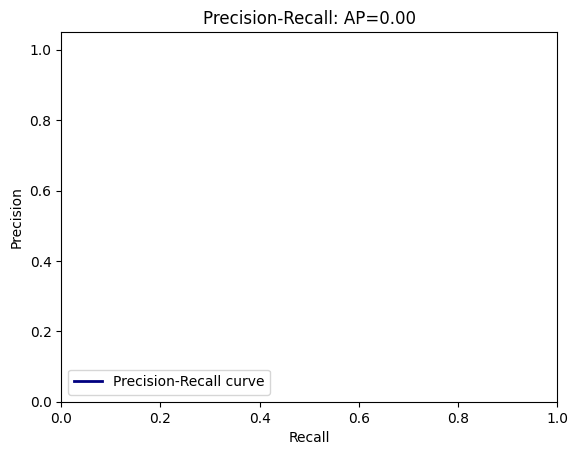

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction = 0.0000


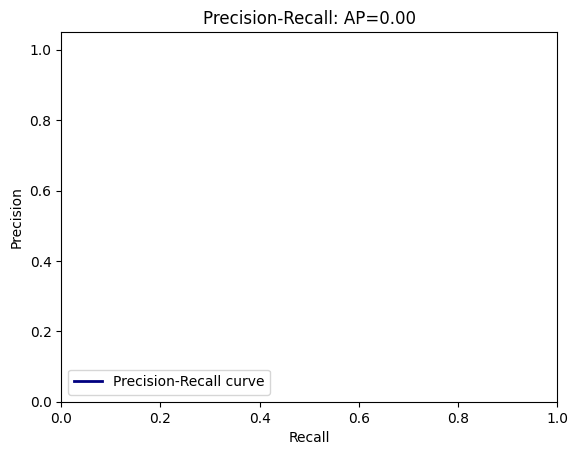

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges = 0.0000


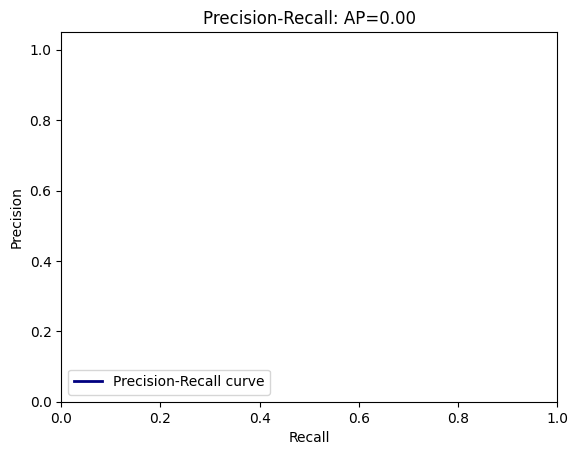

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps = 0.0000


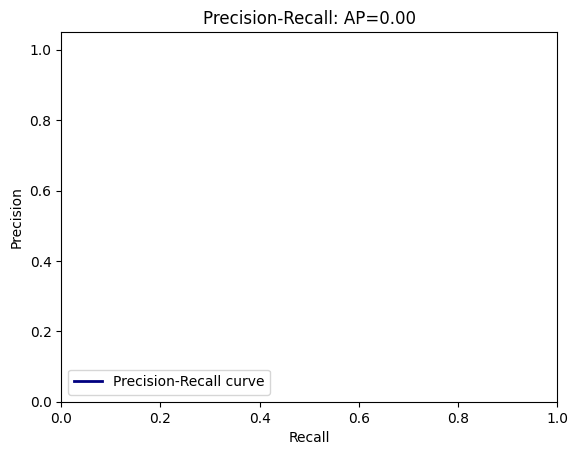

Mean AP = 0.0000
~~~~~~~~
Results:
              class  precision  recall   ap
0       Speed limit        0.0     0.0  0.0
1  Pass either side        0.0     0.0  0.0
2       Obstruction        0.0     0.0  0.0
3  Roadway diverges        0.0     0.0  0.0
4             Bumps        0.0     0.0  0.0


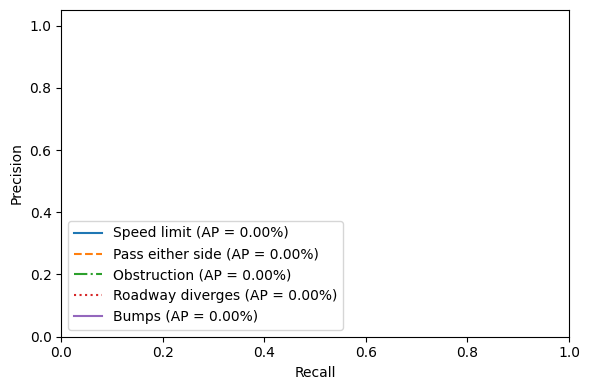

0.0

<Figure size 640x480 with 0 Axes>

In [132]:
compute_mean_average_precision(detections)
# print("----- Small detections -----")
# compute_mean_average_precision(detections_small)
# print("----- Medium detections -----")
# compute_mean_average_precision(detections_medium)
# print("----- Large detections -----")
# compute_mean_average_precision(detections_large)

## Plot detections

In [156]:
filename = '234_png.rf.5ff94e48806d49ca1dff3a862316c202.jpg'
sample = get_detection_by_filename(detections, filename)
sample

{'pred_bboxes': [[[0.03231021761894226,
    0.03316730260848999,
    0.9385552406311035,
    0.9117448329925537]]],
 'pred_classes': [[5]],
 'confidences': [[0.5317991375923157]],
 'gt_bboxes': [[8, 5, 90, 141]],
 'gt_classes': ['Bumps']}

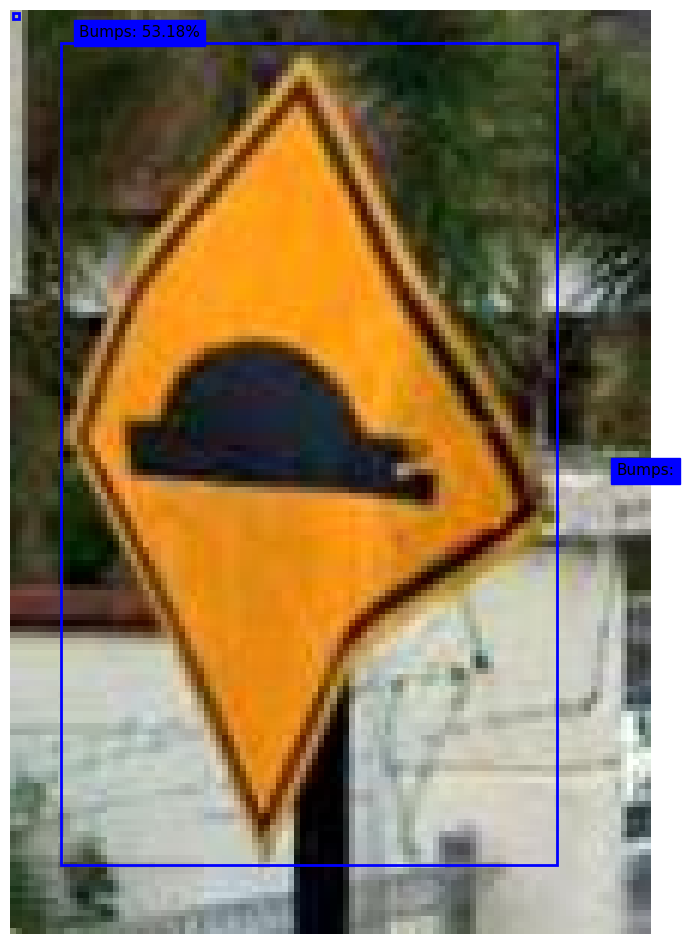

In [157]:
plot_dets(sample, filename)